### H13 (Snow Water Equivalent) product can be analyzed and compared to ERA5 snow density reanalysis data using this module (monthly)

This module is the continuation of the first one. It compares H13 and ERA5 maximum and minimum snow density for selected regions (Norway, Alps and Mountanous Regions of Turkey). 

In [1]:
import os
import glob
import pandas as pd
from osgeo import gdal, ogr, gdal_array
from osgeo.gdalconst import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import gdal
import datetime
from datetime import timedelta
import matplotlib

start = datetime.datetime.strptime("20130101", "%Y%m%d")
end = datetime.datetime.strptime("20191231", "%Y%m%d")
date_list2 = [start + timedelta(n) for n in range(int((end - start).days) + 1)]
df3 = pd.DataFrame({'date':date_list2})


df3['month_year'] = df3['date'].dt.to_period('M')
df3['year']= df3['date'].dt.year
df3['months']= df3['date'].dt.month

dateList3 = df3['month_year'].astype(str).values.tolist()
dateList3 = sorted(list(set(dateList3)))
yearList = df3['year'].astype(str).values.tolist()
monthList1 = df3['months'].astype(str).values.tolist()
uniquemonthList=sorted(map(int,(list(set(monthList1)))))
uniqueyearList= sorted(list(set(yearList)))

yearList = [ele for ele in uniqueyearList for i in range(12)]
monthList = sorted(list(map(int,uniquemonthList)))* 7

process_path = '/home/knn/Desktop/HSAF_Snow_Analysis/SWE/H13_and_ERA5_Comparison_Analysis/era5_test_data'
process_path2 = '/home/knn/Desktop/HSAF_Snow_Analysis/SWE/H13_and_ERA5_Comparison_Analysis/rho_test_data'
file = glob.glob1("./areas_master/", '*.' + 'shp')
file_n = os.path.join('./areas_master/', file[0])


def bbox_to_pixel_offsets(gt, bbox):
    originX = gt[0]
    originY = gt[3]
    pixel_width = gt[1]
    pixel_height = gt[5]
    x1 = int((bbox[0] - originX) / pixel_width)
    x2 = int((bbox[1] - originX) / pixel_width) + 1

    y1 = int((bbox[3] - originY) / pixel_height)
    y2 = int((bbox[2] - originY) / pixel_height) + 1

    xsize = x2 - x1
    ysize = y2 - y1
    return (x1, y1, xsize, ysize)


vds = ogr.Open(file_n, GA_ReadOnly)
assert (vds)
vlyr = vds.GetLayer(0)
layerlen = vlyr.__len__()

layerDefinition = vlyr.GetLayerDefn()
layer_list = []

for i in range(layerDefinition.GetFieldCount()):
    layer_name = layerDefinition.GetFieldDefn(i).GetName()
    layer_list.append(layer_name)

x = layer_list[0]
ID = []
for feature in vlyr:
    feat = feature.GetField(x)
    ID.append(feat)
vlyr.ResetReading()  # reset the read position to the start


def zonal_stats(vector_path, raster_path, nodata_value=None, global_src_extent=False):
    rds = gdal.Open(raster_path, GA_ReadOnly)
    assert (rds)
    rb = rds.GetRasterBand(1)
    rgt = rds.GetGeoTransform()

    if nodata_value:
        nodata_value = float(nodata_value)
        rb.SetNoDataValue(nodata_value)

    vds = ogr.Open(vector_path, GA_ReadOnly)
    assert (vds)
    vlyr = vds.GetLayer(0)

    if global_src_extent:
        src_offset = bbox_to_pixel_offsets(rgt, vlyr.GetExtent())
        src_array = rb.ReadAsArray(*src_offset)

        # calculate new geotransform of the layer subset
        new_gt = (
            (rgt[0] + (src_offset[0] * rgt[1])),
            rgt[1],
            0.0,
            (rgt[3] + (src_offset[1] * rgt[5])),
            0.0,
            rgt[5]
        )

    mem_drv = ogr.GetDriverByName('Memory')
    driver = gdal.GetDriverByName('MEM')

    # Loop through vectors
    stats = []
    feat = vlyr.GetNextFeature()
    while feat is not None:

        if not global_src_extent:
            src_offset = bbox_to_pixel_offsets(rgt, feat.geometry().GetEnvelope())
            src_array = rb.ReadAsArray(*src_offset)

            # calculate new geotransform of the feature subset
            new_gt = (
                (rgt[0] + (src_offset[0] * rgt[1])),
                rgt[1],
                0.0,
                (rgt[3] + (src_offset[1] * rgt[5])),
                0.0,
                rgt[5]
            )

        # Create a temporary vector layer in memory
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', None, ogr.wkbPolygon)
        mem_layer.CreateFeature(feat.Clone())

        # Rasterize it
        rvds = driver.Create('', src_offset[2], src_offset[3], 1, gdal.GDT_Byte)
        rvds.SetGeoTransform(new_gt)
        gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])
        rv_array = rvds.ReadAsArray()

        masked = np.ma.MaskedArray(
            src_array,
            mask=np.logical_or(
                src_array == nodata_value,
                np.logical_not(rv_array)
            )
        )

        sum_all = (masked.data * (np.where(masked.mask == True, False, True))).sum()
        if (sum_all == 0):
            zero_mean = 0
        else:
            x, y = np.unique(masked.filled(), return_counts=True)
            c = dict(zip(x.data, y))

            if 0 in c.keys():
                if masked.count() == c[0]:
                    zero_mean = 0
                else:
                    zero_mean = float(sum_all / (masked.count() - c[0]))
            else:
                zero_mean = masked.mean()

        feature_stats = {
            'min': float(masked.min()),
            'mean': float(masked.mean()),
            'max': float(masked.max()),
            'std': float(masked.std()),
            'sum': float(masked.sum()),
            'count': int(masked.count()),
            'fid': int(feat.GetFID()),
            'mean_wo_zero': zero_mean}

        stats.append(feature_stats)

        rvds = None
        mem_ds = None
        feat = vlyr.GetNextFeature()

    vds = None
    rds = None
    return stats


/home/knn/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:124: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Selection of a Region

Select a region (Alps, Norway or Mountanous regions of Turkey) below. 

In [2]:
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import FileUpload
from auxilary import *
import warnings
warnings.simplefilter("ignore")
import pylab

dec1 = widgets.RadioButtons(
    options=['alps','Norway','turkiye_daglik_alanlar'],
    value = 'alps',
    description='Area',
    disabled=False
)
display(dec1)


RadioButtons(description='Area', options=('alps', 'Norway', 'turkiye_daglik_alanlar'), value='alps')

In [3]:
input_polygon = os.path.join('areas_master',dec1.value + '.shp')
print(input_polygon)

areas_master/Norway.shp


### Monthly Minimum and Maximum Means of ERA5 and H13 for the Selected Region

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


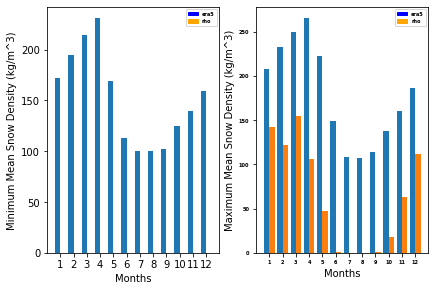

In [4]:
process_data8 = pd.DataFrame(columns=['Date','mean','sum','count', 'std'])
process_data9 = pd.DataFrame(columns=['Date','mean','sum','count', 'std'])
for date in dateList3:
    file = 'era5_'+date+'_cut.tif'
    file2 = 'rho_'+date+'.tif'
    p2 = os.path.join(process_path2,file2)
    p = os.path.join(process_path, file)
    a = zonal_stats(input_polygon, p)
    b = zonal_stats(input_polygon,p2)
    #returns stats for all the dates
    # list_.append(a)

# print(list_)
    era_stats = pd.DataFrame(a)
    rho_stats = pd.DataFrame(b)
    process_data8 = process_data8.append({'Date':str(date), 'mean': era_stats['mean'][i], 'sum': era_stats['sum'][i], 'count': era_stats['count'][i], 'standart_deviation' : era_stats['std'][i]}, ignore_index=True)
    process_data9 = process_data9.append({'Date': str(date), 'mean': rho_stats['mean'][i], 'sum': rho_stats['sum'][i], 'count': rho_stats['count'][i], 'standart_deviation' : rho_stats['std'][i]}, ignore_index=True)
pd_ = process_data8.assign(years = yearList)
pd_['months'] = monthList
pd2_ = process_data9.assign(years = yearList)
pd2_['months'] = monthList

m = [1,2,3,4,5,6,7,8,9,10,11,12]

eramin = []
eramax = []
rhomin = []
rhomax = []
for month in m:
    rslt_df = pd_.loc[pd_['months'] == month]
    rslt_df2 = pd2_.loc[pd2_['months'] == month]
    mean_lera= list(rslt_df['mean'])
    mean_lrho = list(rslt_df2['mean'])
    mean_lrho = [i * 1000 for i in mean_lrho]
    mean_lrho = np.nan_to_num(mean_lrho)
    eramin.append(np.min(mean_lera))
    eramax.append(np.max(mean_lera))
    rhomin.append(np.min(mean_lrho))
    rhomax.append(np.max(mean_lrho))
    
plt.subplot(1, 2, 1)
x=uniquemonthList
_X = np.arange(len(x))
era_y = eramin
rho_y = rhomin


plt.bar(_X - 0.2, era_y, 0.4)
plt.bar(_X + 0.2, rho_y, 0.4)
plt.xticks(_X, x)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

matplotlib.rc('font', **font)
colors = {'era5':'blue', 'rho':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        
plt.xlabel('Months', fontsize=10)
plt.ylabel('Minimum Mean Snow Density (kg/m^3)', fontsize=10)
plt.legend(handles, labels)

plt.subplot(1, 2, 2)

x=uniquemonthList
_X = np.arange(len(x))
era_y = eramax
rho_y = rhomax


plt.bar(_X - 0.2, era_y, 0.4)
plt.bar(_X + 0.2, rho_y, 0.4)
plt.xticks(_X, x)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

matplotlib.rc('font', **font)
colors = {'era5':'blue', 'rho':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        
plt.xlabel('Months', fontsize=10)
plt.ylabel('Maximum Mean Snow Density (kg/m^3)', fontsize=10)
plt.legend(handles, labels)
plt.tight_layout()

plt.show()



### Yearly Minimum and Maximum Means of ERA5 and H13 for the Selected Region

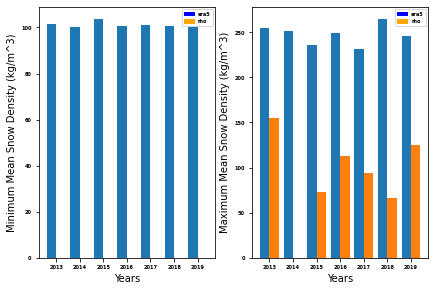

In [5]:
y = ["2013","2014","2015","2016","2017","2018","2019"]
eramin = []
eramax = []
rhomin = []
rhomax = []
for year in y:
    rslt_df = pd_.loc[pd_['years'] == year]
    rslt_df2 = pd2_.loc[pd2_['years'] == year]
   
    mean_lera= list(rslt_df['mean'])
    mean_lrho = list(rslt_df2['mean'])
    mean_lrho = [i * 1000 for i in mean_lrho]
    mean_lrho = np.nan_to_num(mean_lrho)
    eramin.append(np.min(mean_lera))
    eramax.append(np.max(mean_lera))
    rhomin.append(np.min(mean_lrho))
    rhomax.append(np.max(mean_lrho))
    
plt.subplot(1, 2, 1)
x=uniqueyearList
_X = np.arange(len(x))
era_y = eramin
rho_y = rhomin
# plt.figure(figsize=(50,20))

plt.bar(_X - 0.2, era_y, 0.4)
plt.bar(_X + 0.2, rho_y, 0.4)
plt.xticks(_X, x)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

matplotlib.rc('font', **font)
colors = {'era5':'blue', 'rho':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        
plt.xlabel('Years', fontsize=10)
plt.ylabel('Minimum Mean Snow Density (kg/m^3)', fontsize=10)
plt.legend(handles, labels)

plt.subplot(1, 2, 2)

x=uniqueyearList
_X = np.arange(len(x))
era_y = eramax
rho_y = rhomax
# plt.figure(figsize=(50,20))

plt.bar(_X - 0.2, era_y, 0.4)
plt.bar(_X + 0.2, rho_y, 0.4)
plt.xticks(_X, x)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

matplotlib.rc('font', **font)
colors = {'era5':'blue', 'rho':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        
plt.xlabel('Years', fontsize=10)
plt.ylabel('Maximum Mean Snow Density (kg/m^3)', fontsize=10)
plt.legend(handles, labels)
plt.tight_layout()

plt.show()



### Monthly  Means of ERA5 and H13 for the Selected Region

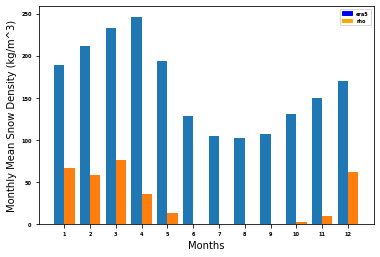

In [7]:
eramean = []
rhomean = []

for month in m:
    rslt_df = pd_.loc[pd_['months'] == month]
    rslt_df2 = pd2_.loc[pd2_['months'] == month]
    mean_lera= list(rslt_df['mean'])
    mean_lrho = list(rslt_df2['mean'])
    mean_lrho = [i * 1000 for i in mean_lrho]
    mean_lrho = np.nan_to_num(mean_lrho)
    eramean.append(np.mean(mean_lera))
    rhomean.append(np.mean(mean_lrho))

    
x=uniquemonthList
_X = np.arange(len(x))
era_y = eramean
rho_y = rhomean


plt.bar(_X - 0.2, era_y, 0.4)
plt.bar(_X + 0.2, rho_y, 0.4)
plt.xticks(_X, x)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

matplotlib.rc('font', **font)
colors = {'era5':'blue', 'rho':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        
plt.xlabel('Months', fontsize=10)
plt.ylabel('Monthly Mean Snow Density (kg/m^3)', fontsize=10)
plt.legend(handles, labels)

plt.show()


### Yearly  Means of ERA5 and H13 for the Selected Region

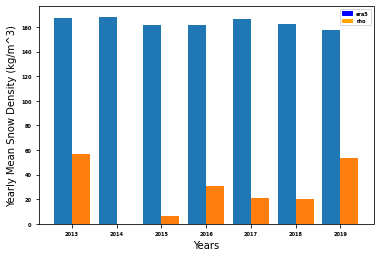

In [11]:
y = ["2013","2014","2015","2016","2017","2018","2019"]
eramean = []
rhomean = []

for year in y:
    rslt_df = pd_.loc[pd_['years'] == year]
    rslt_df2 = pd2_.loc[pd2_['years'] == year]
   
    mean_lera= list(rslt_df['mean'])
    mean_lrho = list(rslt_df2['mean'])
    mean_lrho = [i * 1000 for i in mean_lrho]
    mean_lrho = np.nan_to_num(mean_lrho)
    eramean.append(np.mean(mean_lera))
    rhomean.append(np.mean(mean_lrho))
    
    

x=uniqueyearList
_X = np.arange(len(x))
era_y = eramean
rho_y = rhomean
# plt.figure(figsize=(50,20))

plt.bar(_X - 0.2, era_y, 0.4)
plt.bar(_X + 0.2, rho_y, 0.4)
plt.xticks(_X, x)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

matplotlib.rc('font', **font)
colors = {'era5':'blue', 'rho':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        
plt.xlabel('Years', fontsize=10)
plt.ylabel('Yearly Mean Snow Density (kg/m^3)', fontsize=10)
plt.legend(handles, labels)

plt.show()
